### HDRM

In [5]:
import numpy as np

class HDRMPlanner:
    def __init__(self, dof=3, disc=3):
        self.dof = dof
        self.disc = disc
        self.K = self.disc*np.ones(self.dof, dtype=np.int64) # 3 indices per dof
        self.start_node = None
        self.end_node = None
        self.motion = self.get_motion_model(self.dof)
        self.occupied_vertices = None
        
    class Node:
        def __init__(self, index, cost, parent_index):
            self.index = index
            self.cost = cost
            self.parent_index = parent_index
            
        def __str__(self):
            return "Index = " + str(self.index) + ", cost = " + str(self.cost)
        
    # Algorithm 1: Get hierarchical index from integer index
    def get_hierarchical_index_from_integer_index(self, n, i):
        k = np.zeros(n, dtype=np.int64)
        for j in range(n-1, -1, -1):
            i,k[j] = np.divmod(i, self.K[j])
            if i!=0 and k[j]==0:
                k[j] = self.K[j]
            else:
                i = i+1
        return k

    # Algorithm 2: Get integer index from hierarchical index
    def get_integer_index_from_hierarchical_index(self, k):
        i = k[0]
        n = len(k)
        for j in range(1,n):
            i = (i-1)*self.K[j]+k[j]
        return n,i

    def set_occupied_index(self, index):
        self.occupied_vertices = index
    
    def astar_planning(self, start_index, end_index, max_iter=10000):
        """
        """
        # assume start_q and end_q are indices for now
        self.start_node = self.Node(start_index, 0, -1)
        self.end_node = self.Node(end_index, 0, -1)
        
        print(f"start node = {self.start_node.index}, conf = {self.get_hierarchical_index_from_integer_index(self.dof, self.start_node.index)}")
        print(f"end node = {self.end_node.index}, conf = {self.get_hierarchical_index_from_integer_index(self.dof, self.end_node.index)}")
        
        open_set, closed_set = dict(), dict()
        open_set[int(self.start_node.index)] = self.start_node
        
        for loop in range(max_iter):
            # search iteration maxed out
            if loop == (max_iter-1):
                print(f"Max iteration for search")
            
            # graph fully explored
            if len(open_set) == 0:
                print(f"Loop = {loop}, no solution since open set is empty ...")
                break
                
            # index with the smallest cost in the open set
            current_index = min(
                open_set, 
                key=lambda o: open_set[o].cost + self.calc_heuristic(self.end_node, open_set[o]))

            # current node
            current = open_set[current_index]
            
            # found goal
            if current.index == self.end_node.index:
                print(f"Found goal at loop = {loop}")
                self.end_node.parent_index = current.parent_index
                self.end_node.cost = current.cost
                break
                
            # remove current node from open set and add into closed_set
            del open_set[current.index]
            closed_set[int(current.index)] = current
            
            # search based on motion model
            for i,m in enumerate(self.motion):
                current_configuration = self.get_hierarchical_index_from_integer_index(self.dof, current.index)
                new_configuration = current_configuration+m[:self.dof];
                
                if self.is_configuration_valid(new_configuration):
                    _, new_index = self.get_integer_index_from_hierarchical_index(new_configuration)
                    node = self.Node(new_index, current.cost+m[-1], current.index)
                    
                    # ignore node is in collision with obstacle
                    if self.colliding_with_obstacle(int(node.index)):
                        continue
                        
                    # ignore node that is already considered
                    if node.index in closed_set:
                        continue
                        
                    # new node that is not in the open set
                    if node.index not in open_set:
                        open_set[int(node.index)] = node
                    else:
                        if open_set[node.index].cost > node.cost:
                            # replace the path this node was using with this one
                            open_set[int(node.index)] = node
        
        return self.get_final_path(self.end_node, closed_set)
        
    @staticmethod
    def get_motion_model(dof):
        # q1, q2, q3, ... cost
        # we can only move one step at each level
        pos = np.diag(np.ones(dof))
        neg = -1*np.diag(np.ones(dof))
        pos = pos.astype(int)
        neg = neg.astype(int)
        
        motion = np.row_stack((pos, neg))
        cost = np.ones(2*dof)
        return np.column_stack((motion, cost[..., None]))
    
    def is_configuration_valid(self, cfg):
        for i in range(self.dof):
            if cfg[i] <= 0 or cfg[i] > self.disc:
                return False
        return True
    
    def calc_heuristic(self, n1, n2):
        q1 = self.get_hierarchical_index_from_integer_index(self.dof, n1.index)
        q2 = self.get_hierarchical_index_from_integer_index(self.dof, n2.index)
        
        w = 1.0 # weight of heuristic
        return w * np.linalg.norm(q1-q2)
        
    def colliding_with_obstacle(self, cfg):
#         print(f"cfg = {cfg}, occupied = {cfg in self.occupied_vertices}")
        return cfg in self.occupied_vertices
    
    def get_final_path(self, end_node, closed_set):
        path = []
        path.append(self.get_hierarchical_index_from_integer_index(self.dof, end_node.index))
        parent_index = end_node.parent_index
        while parent_index != -1:
            curr_node = closed_set[parent_index]
            curr_cfg = self.get_hierarchical_index_from_integer_index(self.dof, curr_node.index)
            path.insert(0, curr_cfg)
            parent_index = curr_node.parent_index
            
        return path
        

start node = 1, conf = [1 1 1]
end node = 1000, conf = [10 10 10]
Found goal at loop = 984


<IPython.core.display.Javascript object>


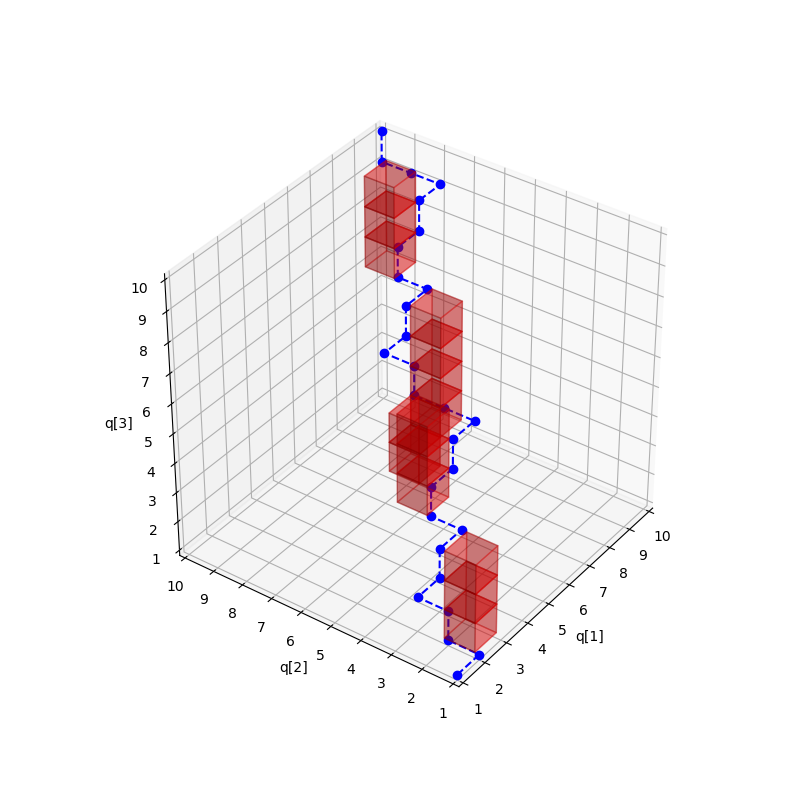

In [6]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

def plot_voxel(ax, pos, scale, alp=0.5, clr='red'):
    r = [-1,1]
    X, Y = np.meshgrid(r, r)
    o = scale*np.ones(4).reshape(2, 2)
    X = scale*X
    Y = scale*Y
    ax.plot_surface( X+pos[0],  Y+pos[1],  o+pos[2], alpha=alp, facecolors=clr)
    ax.plot_surface( X+pos[0],  Y+pos[1], -o+pos[2], alpha=alp, facecolors=clr)
    ax.plot_surface( X+pos[0], -o+pos[1],  Y+pos[2], alpha=alp, facecolors=clr)
    ax.plot_surface( X+pos[0],  o+pos[1],  Y+pos[2], alpha=alp, facecolors=clr)
    ax.plot_surface( o+pos[0],  X+pos[1],  Y+pos[2], alpha=alp, facecolors=clr)
    ax.plot_surface(-o+pos[0],  X+pos[1],  Y+pos[2], alpha=alp, facecolors=clr)
    
#     ax.scatter3D(pos[0], pos[1], pos[2], 'ko')
    
# settings
dof = 3
discretization = 10

# hdrm
a = HDRMPlanner(dof, discretization)

# obstacles
obs = {211,212,213,443,444,445,554,553,654,655,656,657,887,888,889}
a.set_occupied_index(obs)

# astar planning
path = a.astar_planning(1, pow(discretization,dof), 10000)

fig = plt.figure(figsize=(8,8)) 
ax = fig.add_subplot(111,projection='3d') 

# plot obstacle
for o in a.occupied_vertices:
    k = a.get_hierarchical_index_from_integer_index(a.dof, o)
    plot_voxel(ax, k, 0.5, alp=0.3, clr='red')
    
# plot path
path = np.asarray(path)
ax.plot(path[:,0], path[:,1], path[:,2], 'bo--')

ticks = np.arange(1, discretization+1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)

minmax = [np.min(ticks), np.max(ticks)]
ax.set_xlim(minmax)
ax.set_ylim(minmax) 
ax.set_zlim(minmax)

ax.set_xlabel('q[1]')
ax.set_ylabel('q[2]')
ax.set_zlabel('q[3]')
plt.show()
